June 29th  
Now try to simulate the Delta7 network using the average recurrent connectivity profile. This notebook assumes that within glomerular connections are 0 (and the other lets them be inhibitory)

In [1]:
import sys, os, glob
import datetime, time

import numpy as np
from numpy import linalg as nla
import scipy.linalg as sla
import numpy.random as nrd

# import scipy.stats as sst

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

gen_fns_dir = os.path.abspath('../shared')
sys.path.append(gen_fns_dir)
from general_file_fns import load_pickle_file, save_pickle_file
import conn_data_analysis_fns as cdaf
import ring_net_fns as rnf

curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'
#sd=int((time.time()%1)*(2**31))
# rng = nrd.default_rng(sd)
# print('Seed= ',sd)

In [2]:
# Load the connectivity profile (which was extracted using the other functions in this directory).
# Change data_path to where you put it.
data_path = '../delta7_rec_matrices/'
fname = 'delta7_delta7_average_profiles.p'
conn = load_pickle_file(data_path + fname)
print(conn.keys())

dict_keys(['subtype_list', 'neuron_list', 'subtype_idx', 'subtype_boundaries', 'raw_conn_matrix', 'norm_conn_matrix', 'subtype_rec_matrix', 'subtype_avg_input', 'subtype_avg_output', 'left_glom_list', 'right_glom_list', 'left_glom_idx', 'right_glom_idx', 'left_glom_rec_matrix', 'left_glom_avg_input', 'left_glom_avg_output', 'right_glom_rec_matrix', 'right_glom_avg_input', 'right_glom_avg_output', 'glom_avg_input', 'glom_avg_output', 'n_gloms'])


In [3]:
# We're particularly interested in the average input and output profile (i.e., averaged across glomeruli)
n_gloms = conn['n_gloms']
glom_avg_input = conn['glom_avg_input']
glom_avg_output = conn['glom_avg_output']

In [4]:
print(glom_avg_input)

[0.15486901 0.15601156 0.11619277 0.08521092 0.13174347 0.08732954
 0.11803541 0.15060732]


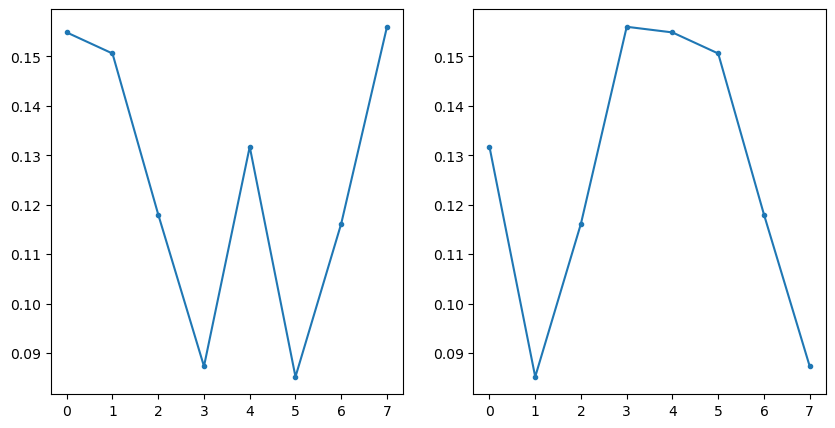

In [5]:
# To make a connectivity matrix, we need to shift the average profile to center it around each
# glomerulus in turn. To start with, get the correct shift for the first glomerulus
first_col = np.roll(glom_avg_output, -4)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(glom_avg_output, marker='.')
ax[1].plot(first_col, marker='.')

In [6]:
# Now use the circulant function and the profile of first glomerulus to generate the whole connectivity matrix 
W = sla.circulant(first_col)
# Copy it into a new matrix and zero out the within-glomerular connections (other notebook keeps these)
W_zd = np.array(W)
np.fill_diagonal(W_zd, 0)

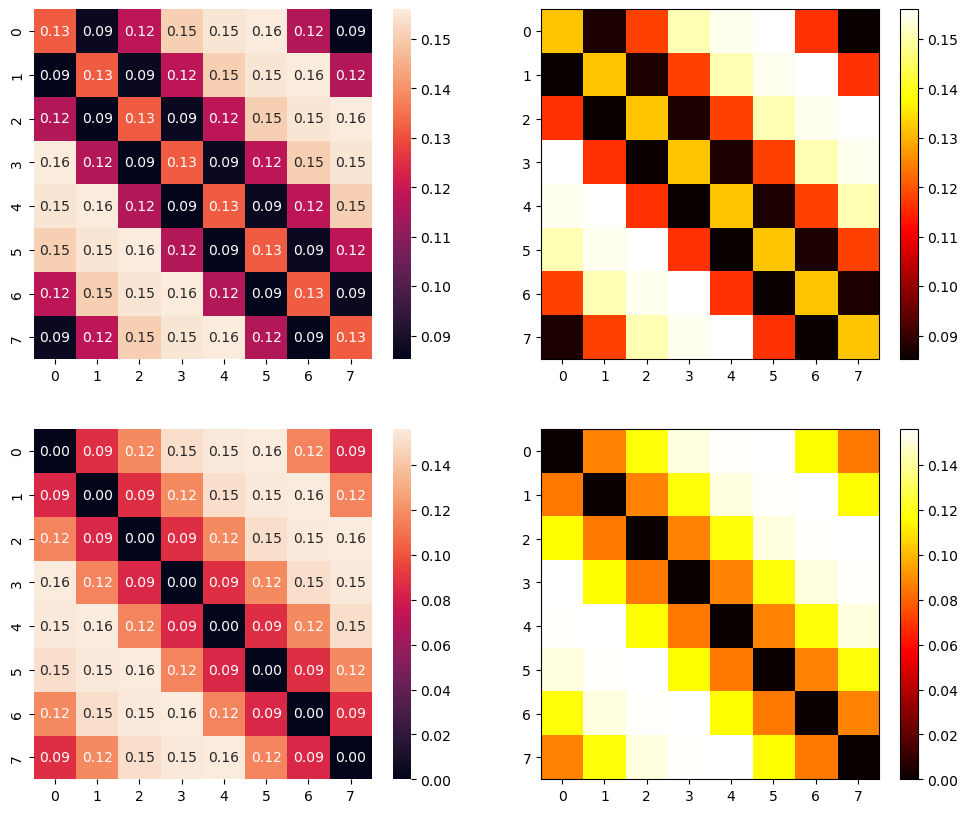

In [7]:
# Plot the connectivity matrices, with and without zeroing out the diagonal
fig, ax = plt.subplots(2,2,figsize=(12, 10))
sns.heatmap(W, cmap="rocket", annot=True, fmt=".2f", ax=ax[0,0])
# ax[0].invert_yaxis()
p = ax[0,1].imshow(W, aspect='auto', interpolation='nearest', cmap='hot')
fig.colorbar(p, ax=ax[0, 1])

sns.heatmap(W_zd, cmap="rocket", annot=True, fmt=".2f", ax=ax[1,0])
# ax[0].invert_yaxis()
p = ax[1,1].imshow(W_zd, aspect='auto', interpolation='nearest', cmap='hot')
fig.colorbar(p, ax=ax[1, 1])


In [8]:
np.allclose(W[:,0], first_col)

True

In [9]:
# Some simple functions to quickly simulate a noiseless network with a threshold linear nonlinearity

def relu(x):
    '''Returns 0 if x<0 and x otherwise'''
    return np.maximum(x, 0)

def simulate_network(W, b, x0, time_to_run, dt):
    '''Simulate the network using Euler's method.
    Inputs:
    W:             N x N connectivity matrix
    x0:            N-dimensional initial condition
    time_to_run    how long to simulate for
    dt             simulation step size
    
    Returns an n_times x N matrix containing the simulated system. Note
    that each row is a time point and each column a neuron. 
    '''
    
    n_steps = np.round(time_to_run / dt).astype(int)
    N = W.shape[0] # Number of neurons
    
    # We'll store outputs here
    x = np.zeros((n_steps + 1, N))
    x[0] = np.array(x0)
    
    for i in range(1, n_steps + 1):
        x[i] = x[i-1] + dt * (-x[i-1] + relu(W @ x[i-1] + b))
    
    t = dt * np.arange(n_steps + 1) # Make the time points too for plotting
    return x, t
    

In [10]:
# Set up some parameters and simulate. 
# Here beta is a scaling parameter that converts the glomerular connection counts
# to connection strengths and b is a background bias or excitability that allows 
# neurons to be active despite receiving recurrent inhibitory input
# beta = -8, b=25 gives 3 glom wide bump
beta = -5
#beta = -8
b = 25
W_rec = beta * W_zd # Connectivity matrix used
# Initial conditions
x0 = np.array([10, 5, 2, 0, 0, 0, 2, 5.])
x0 = np.roll(x0, 3)
time_to_run = 100.
dt = 0.05

x, t = simulate_network(W_rec, b, x0, time_to_run, dt)

[Text(0.5, 0, 'Glomerulus'), Text(0, 0.5, 'Rate')]

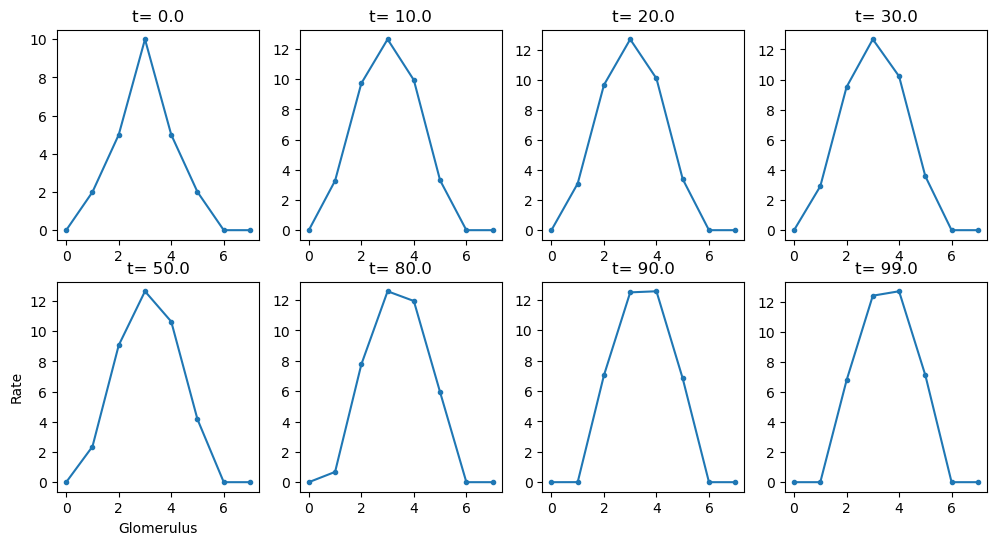

In [11]:
# Plot network activity
# time_points = np.array([0, 1, 2, 3, 4, 5, 6, 6.9])
time_points = np.array([0, 10, 20, 30, 50, 80, 90, 99])
time_idx = np.round(time_points/dt).astype(int)
fig, axes = plt.subplots(2,4,figsize=(12,6))
for tid, ax in zip(time_idx, axes.flatten()):
    ax.plot(x[tid], marker='.')
    ax.set(title='t= '+str(t[tid]))
axes[1,0].set(xlabel='Glomerulus', ylabel='Rate')

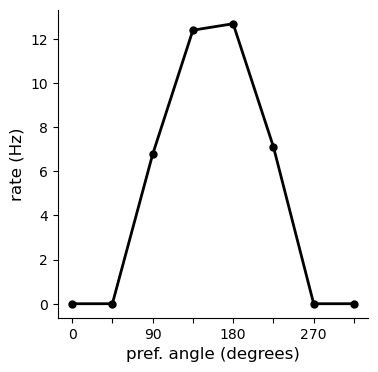

In [12]:
# Slightly nicer plot to show inhibitory bump
xtl = ['0', '', '90', '', '180', '', '270', '']
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(np.arange(8), x[time_idx[-1]], marker='.', lw=2, markersize=10, color='k')
ax.set_xticks(np.arange(8), labels=xtl)
ax.set_xlabel('pref. angle (degrees)', fontsize=12)
ax.set_ylabel('rate (Hz)', fontsize=12)
# ax.set(xlabel=, ylabel='')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig('inh_bump.pdf')

[Text(0.5, 0, 'time (s)'), Text(0, 0.5, 'glomerulus')]

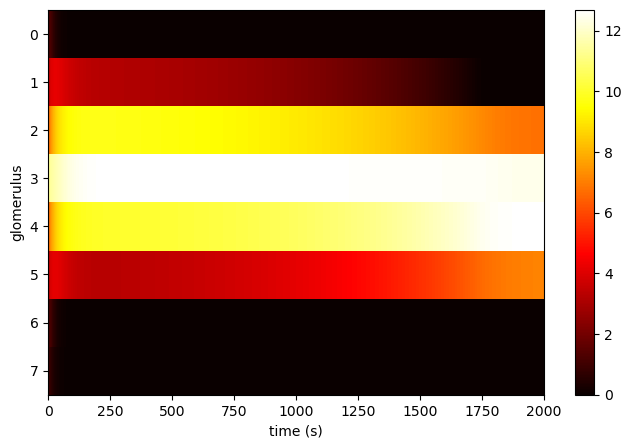

In [13]:
# Heatmap of activity
fig, ax = plt.subplots(1,1,figsize=(8,5))
# sns.heatmap(x.T, cmap="rocket")
p = ax.imshow(x.T, aspect='auto', interpolation='nearest', cmap='hot')
fig.colorbar(p, ax=ax)
ax.set(xlabel='time (s)', ylabel='glomerulus')

In [14]:
# Look at input to network on last time step
W_rec @ x[-1] + b

array([-3.6906165 , -0.3258617 ,  6.74199626, 12.3806486 , 12.69098942,
        7.13199887, -0.29453333, -3.70894406])

Scratch pad --- just messing around to try to find good parameters

In [15]:
x0 = np.array([10, 5, 2, 0, 0, 0, 2, 5.])
beta = -8
x1 = beta * W_zd @ x0
print(x1)
print(x1 + 25)

[-10.64926917 -15.35804171 -21.42222492 -27.09648797 -28.40192694
 -26.85821993 -21.43821153 -15.48087146]
[14.35073083  9.64195829  3.57777508 -2.09648797 -3.40192694 -1.85821993
  3.56178847  9.51912854]


In [16]:
beta = -8
b = 25
W_rec = beta * W_zd
x0 = np.array([10, 5, 2, 0, 0, 0, 2, 5.])
print(W_rec @ x0 + b)

x1 = relu(W_rec @ x0 + b)
print(x1)
print(W_rec @ x1 + b)

[14.35073083  9.64195829  3.57777508 -2.09648797 -3.40192694 -1.85821993
  3.56178847  9.51912854]
[14.35073083  9.64195829  3.57777508  0.          0.          0.
  3.56178847  9.51912854]
[  5.08544262  -0.57614774 -11.20604833 -20.3977656  -22.97215713
 -20.17906804 -11.25145214  -0.86942095]


Now try Poisson spiking. Later move to own notebook

In [17]:
beta = -5
W_rec = beta * W_zd
bias = 25
time_to_run = 100
dt = 0.05

# x, t = simulate_network(W_rec, b, x0, time_to_run, dt)

x0 = np.array([10, 5, 2, 0, 0, 0, 2, 5.])
x0 = np.roll(x0, 3)

params = {'dt' : dt, 'tau' : 1, 'ics' : x0, 'bias' : bias, 'fi' : relu}
params['nSteps'] = int(time_to_run/params['dt'])

In [18]:
tic = time.time()
s, rates = rnf.simulate_lnp_net(W_rec, params)
t = np.arange(params['nSteps'])*params['dt']
print('Sim time ', time.time()-tic)

Sim time  0.02880120277404785


In [19]:
t[-1]

99.95

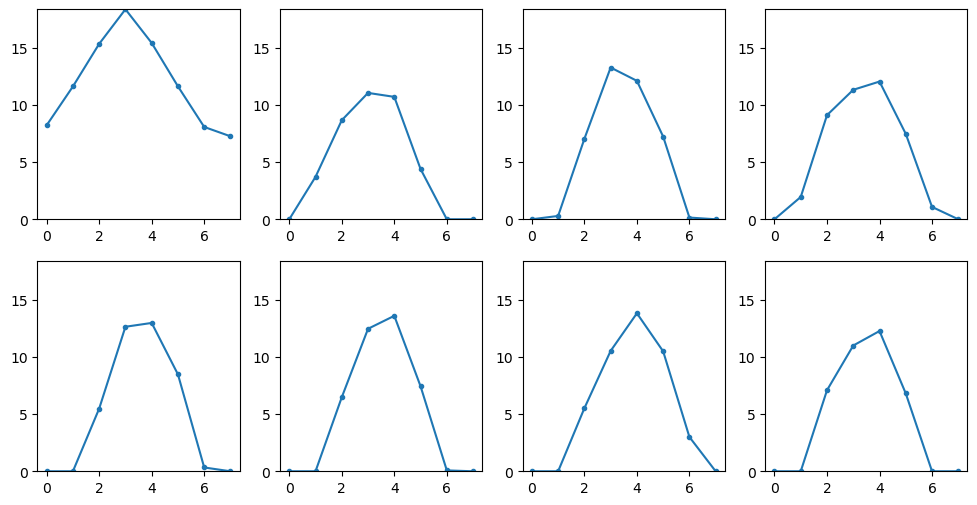

In [20]:
time_points = np.array([0, 10, 20, 30, 50, 80, 90, 99])
time_idx = np.round(time_points/dt).astype(int)
fig, axes = plt.subplots(2,4,figsize=(12,6))
for tid, ax in zip(time_idx, axes.flatten()):
    ax.plot(rates[tid], marker='.')
    ax.set(ylim=[0, np.max(rates)])